In [1]:
import sys
import gc
import pandas as pd
import matplotlib
import numpy as np
import scipy as sp
from scipy import stats
from scipy.stats import norm,skew,kurtosis #for some statistics
import IPython
from IPython import display
import sklearn
import random
import time
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
%matplotlib inline
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
input_path = './data/'
train_data = pd.read_csv(input_path+'happiness_train_complete.csv',sep=',',encoding='latin-1')
test_data = pd.read_csv(input_path+'happiness_test_complete.csv',sep=',',encoding='latin-1')
submit_example = pd.read_csv(input_path+'happiness_submit.csv',sep=',',encoding='latin-1')

print('train shape:',train_data.shape)
print('test shape:',test_data.shape)
print('sample shape:',submit_example.shape)

train shape: (8000, 140)
test shape: (2968, 139)
sample shape: (2968, 2)


In [3]:
train_data = train_data[train_data["happiness"]!=-8].reset_index(drop=True)#注意drop=True
print('train shape:',train_data.shape)
train_data_copy = train_data.copy()
target_col = "happiness"
target = train_data_copy[target_col]#.apply(lambda x:np.log1p(x))
del train_data_copy[target_col]

train_shape = train_data.shape[0]
data = pd.concat([train_data_copy,test_data],axis=0,ignore_index=True)
data.head()

train shape: (7988, 140)


,id,survey_type,province,city,county,survey_time,gender,birth,nationality,religion,...,neighbor_familiarity,public_service_1,public_service_2,public_service_3,public_service_4,public_service_5,public_service_6,public_service_7,public_service_8,public_service_9
0,1,1,12,32,59,2015/8/4 14:18,1,1959,1,1,...,4,50,60.0,50,50,30.0,30,50,50,50
1,2,2,18,52,85,2015/7/21 15:04,1,1992,1,1,...,3,90,70.0,70,80,85.0,70,90,60,60
2,3,2,29,83,126,2015/7/21 13:24,2,1967,1,0,...,4,90,80.0,75,79,80.0,90,90,90,75
3,4,2,10,28,51,2015/7/25 17:33,2,1943,1,1,...,3,100,90.0,70,80,80.0,90,90,80,80
4,5,1,7,18,36,2015/8/10 9:50,2,1994,1,1,...,2,50,50.0,50,50,50.0,50,50,50,50


In [4]:
#make feature
def getres1(row):
    return len([x for x in row.values if type(x)==int and x<0])

def getres2(row):
    return len([x for x in row.values if type(x)==int and x==-8])

def getres3(row):
    return len([x for x in row.values if type(x)==int and x==-1])

def getres4(row):
    return len([x for x in row.values if type(x)==int and x==-2])

def getres5(row):
    return len([x for x in row.values if type(x)==int and x==-3])

#调查问卷有效程度
data['neg1'] = data[data.columns].apply(lambda row:getres1(row),axis=1)
data.loc[data['neg1']>20,'neg1'] = 20  #平滑处理

data['neg2'] = data[data.columns].apply(lambda row:getres2(row),axis=1)
data['neg3'] = data[data.columns].apply(lambda row:getres3(row),axis=1)
data['neg4'] = data[data.columns].apply(lambda row:getres4(row),axis=1)
data['neg5'] = data[data.columns].apply(lambda row:getres5(row),axis=1)


data.loc[data['health_problem']<0,'health_problem'] = 0

data.loc[data['religion']<0,'religion'] = 1
data.loc[data['religion_freq']<0,'religion_freq'] = 1
data.loc[data['edu']<0,'edu'] = 0
data.loc[data['edu_status']<0,'edu_status'] = 0
data.loc[data['income']<0,'income'] = 0
data.loc[data['s_income']<0,'s_income']= 0
#对体重修正
data.loc[(data['weight_jin']<=80)&(data['height_cm']>=160),'weight_jin']= data['weight_jin']*2
data.loc[data['weight_jin']<=60,'weight_jin']= data['weight_jin']*2
data.loc[data['family_income']<=0,'family_income']=0
data.loc[data['inc_exp']<=0,'inc_exp']= 0

data.loc[data['equity']<0,'equity'] = 0
data.loc[data['social_neighbor']<0,'social_neighbor'] = 0

data.loc[data['class_10_after']<0,'class_10_after'] = 0
data.loc[data['class_10_before']<0,'class_10_before'] = 0
data.loc[data['class']<0,'class'] = 0
data.loc[data['class_14']<0,'class_14'] = 0
data.loc[data['family_m']<0,'family_m'] = 1

data.loc[data['health']<0,'health'] = 0
data.loc[data['health_problem']<0,'health_problem'] = 0

data.loc[data['neighbor_familiarity']<0,'neighbor_familiarity'] = 0

data.loc[data['inc_ability']<0,'inc_ability'] = np.nan

data.loc[data['status_peer']<0,'status_peer'] = 2
data.loc[data['status_3_before']<0,'status_3_before'] = 2
#部分特征处理
data.loc[data['edu_yr']<0,'edu_yr'] = 0
data['survey_time'] = pd.to_datetime(data['survey_time'])
data.loc[data['marital_1st']<0,'marital_1st']= np.nan
data.loc[data['marital_now']<0,'marital_now']= np.nan


data.loc[data['join_party']<0,'join_party']= np.nan

for i in range(1,12+1):
    data.loc[data['leisure_'+str(i)]<0,'leisure_'+str(i)] = 6
for i in range(1,9+1):
    data.loc[data['public_service_'+str(i)]<0,'public_service_'+str(i)] = data['public_service_'+str(i)].dropna().mode().values
for i in range(1,13+1):
    data.loc[data['trust_'+str(i)]<0,'trust_'+str(i)] = data['trust_'+str(i)].dropna().mode().values

#毕业年龄
data['edubir'] = data['edu_yr'] - data['birth'] 
#调查年龄
data['survey_age'] = 2015-data['birth']
#毕业后调查年数差
data['survey_edu_age'] = 2015-data['edu_yr']

#调查月、时
data['survey_month'] = data['survey_time'].dt.month
data['survey_hour']= data['survey_time'].dt.hour

#第一次结婚年龄
data['marital_1stbir'] = data['marital_1st'] - data['birth'] 
#最近结婚年龄
data['marital_nowtbir'] = data['marital_now'] - data['birth'] 
#是否再婚
data['mar'] = data['marital_nowtbir'] - data['marital_1stbir']
#配偶年龄
data['marital_sbir'] = data['marital_now']-data['s_birth']
#配偶年龄差
data['age_'] = data['marital_nowtbir'] - data['marital_sbir'] 

#收入比
data['income/s_income'] = data['income']/(data['s_income']+1)
data['income+s_income'] = data['income']+(data['s_income']+1)
data['income/family_income'] = data['income']/(data['family_income']+1)
data['all_income/family_income'] = (data['income']+data['s_income'])/(data['family_income']+1)
data['income/inc_exp'] = data['income']/(data['inc_exp']+1)
data['family_income/m'] = data['family_income']/(data['family_m']+0.01)

#收入/面积比
data['income/floor_area'] = data['income']/(data['floor_area']+0.01)
data['all_income/floor_area'] = (data['income']+data['s_income'])/(data['floor_area']+0.01)
data['family_income/floor_area'] = data['family_income']/(data['floor_area']+0.01)

data['income/m'] = data['floor_area']/(data['family_m']+0.01)

#class
data['class_10_diff'] = (data['class_10_after'] - data['class_10_before'])
data['class_diff'] = data['class'] - data['class_10_before']
data['class_14_diff'] = data['class'] - data['class_14']


#province mean
data['province_income_mean'] = data.groupby(['province'])['income'].transform('mean').values
data['province_family_income_mean'] = data.groupby(['province'])['family_income'].transform('mean').values
data['province_equity_mean'] = data.groupby(['province'])['equity'].transform('mean').values
data['province_depression_mean'] = data.groupby(['province'])['depression'].transform('mean').values
data['province_floor_area_mean'] = data.groupby(['province'])['floor_area'].transform('mean').values

#city   mean
data['city_income_mean'] = data.groupby(['city'])['income'].transform('mean').values
data['city_family_income_mean'] = data.groupby(['city'])['family_income'].transform('mean').values
data['city_equity_mean'] = data.groupby(['city'])['equity'].transform('mean').values
data['city_depression_mean'] = data.groupby(['city'])['depression'].transform('mean').values
data['city_floor_area_mean'] = data.groupby(['city'])['floor_area'].transform('mean').values


#county  mean
data['county_income_mean'] = data.groupby(['county'])['income'].transform('mean').values
data['county_family_income_mean'] = data.groupby(['county'])['family_income'].transform('mean').values
data['county_equity_mean'] = data.groupby(['county'])['equity'].transform('mean').values
data['county_depression_mean'] = data.groupby(['county'])['depression'].transform('mean').values
data['county_floor_area_mean'] = data.groupby(['county'])['floor_area'].transform('mean').values

#ratio 相比同个城市
data['income/county'] = data['income']/(data['county_income_mean']+1)                                      
data['family_income/county'] = data['family_income']/(data['county_family_income_mean']+1)   
data['equity/county'] = data['equity']/(data['county_equity_mean']+1)       
data['depression/county'] = data['depression']/(data['county_depression_mean']+1)                                                
data['floor_area/county'] = data['floor_area']/(data['county_floor_area_mean']+1)   

#age   mean
data['age_income_mean'] = data.groupby(['survey_age'])['income'].transform('mean').values
data['age_family_income_mean'] = data.groupby(['survey_age'])['family_income'].transform('mean').values
data['age_equity_mean'] = data.groupby(['survey_age'])['equity'].transform('mean').values
data['age_depression_mean'] = data.groupby(['survey_age'])['depression'].transform('mean').values
data['age_floor_area_mean'] = data.groupby(['survey_age'])['floor_area'].transform('mean').values
data['age_health_mean'] = data.groupby(['survey_age','gender'])['health'].transform('mean').values
data['age_edu_mean'] = data.groupby(['survey_age','gender'])['edu'].transform('mean').values


#age/gender   mean
data['age_income_mean'] = data.groupby(['survey_age','gender'])['income'].transform('mean').values
data['age_family_income_mean'] = data.groupby(['survey_age','gender'])['family_income'].transform('mean').values
data['age_equity_mean'] = data.groupby(['survey_age','gender'])['equity'].transform('mean').values
data['age_depression_mean'] = data.groupby(['survey_age','gender'])['depression'].transform('mean').values
data['age_floor_area_mean'] = data.groupby(['survey_age','gender'])['floor_area'].transform('mean').values
# data['age_BMI_mean'] = data.groupby(['survey_age','gender'])['BMI'].transform('mean').values
data['age_gender_health_mean'] = data.groupby(['survey_age','gender'])['health'].transform('mean').values


#class   mean
data['city_class_income_mean'] = data.groupby(['class'])['income'].transform('mean').values
data['city_class_family_income_mean'] = data.groupby(['class'])['family_income'].transform('mean').values
data['city_class_equity_mean'] = data.groupby(['class'])['equity'].transform('mean').values
data['city_class_depression_mean'] = data.groupby(['class'])['depression'].transform('mean').values
data['city_class_floor_area_mean'] = data.groupby(['class'])['floor_area'].transform('mean').values

#悠闲指数
leisure_fea_lis = ['leisure_'+str(i) for i in range(1,13)]
data['leisure_sum'] = data[leisure_fea_lis].sum() #skew

#满意指数
public_service_fea_lis = ['public_service_'+str(i) for i in range(1,10)]
data['public_service_'] = data[public_service_fea_lis].sum() #skew

data['city_public_service__mean'] = data.groupby(['city'])['public_service_'].transform('mean').values
data['public_service_cit'] = data['public_service_']-data['city_public_service__mean'] 

#信任指数
trust_fea_lis = ['trust_'+str(i) for i in range(1,10)]
data['trust_'] = data[trust_fea_lis].sum() #skew

#入党时间   
data['survey_edu_age'] = 2015-data['join_party']
data['survey_edu_age'].fillna(0,inplace=True)
del data['join_party']
del data['property_other']
del data['id']

In [5]:
data.fillna(-1,inplace=True)
print('shape',data.shape)
data.head()

shape (10956, 202)


,survey_type,province,city,county,survey_time,gender,birth,nationality,religion,religion_freq,...,city_class_income_mean,city_class_family_income_mean,city_class_equity_mean,city_class_depression_mean,city_class_floor_area_mean,leisure_sum,public_service_,city_public_service__mean,public_service_cit,trust_
0,1,12,32,59,2015-08-04 14:18:00,1,1959,1,1,1,...,24641.040816,39486.643537,3.026531,3.650340,107.158027,-1.0,-1.0,-1.0,-1.0,-1.0
1,2,18,52,85,2015-07-21 15:04:00,1,1992,1,1,1,...,43440.000000,104062.576164,3.337806,4.023678,124.915075,-1.0,-1.0,-1.0,-1.0,-1.0
2,2,29,83,126,2015-07-21 13:24:00,2,1967,1,0,3,...,32394.183206,70886.476441,3.281390,3.943143,122.765315,-1.0,-1.0,-1.0,-1.0,-1.0
3,2,10,28,51,2015-07-25 17:33:00,2,1943,1,1,1,...,32394.183206,70886.476441,3.281390,3.943143,122.765315,-1.0,-1.0,-1.0,-1.0,-1.0
4,1,7,18,36,2015-08-10 09:50:00,2,1994,1,1,1,...,15683.065089,31480.699052,2.732544,3.363314,97.374911,-1.0,-1.0,-1.0,-1.0,-1.0


In [11]:
#使用所有特征
use_fea = [clo for clo in data.columns if clo!='survey_time' and data[clo].dtype!=object]
features = data[use_fea].columns
X_train = data[:train_shape][use_fea].values
y_train = target
X_test = data[train_shape:][use_fea].values

from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error,mean_absolute_error, f1_score
import lightgbm as lgb
import xgboost as xgb
import os
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import  KFold, StratifiedKFold,GroupKFold, RepeatedKFold
import logging

##### lgb
param = {
'num_leaves': 80,
'min_data_in_leaf': 40,
'objective':'regression',
'max_depth': -1,
'learning_rate': 0.1,
"min_child_samples": 30,
"boosting": "gbdt",
"feature_fraction": 0.9,
"bagging_freq": 2,
"bagging_fraction": 0.9,
"bagging_seed": 2029,
"metric": 'mse',
"lambda_l1": 0.1,
"lambda_l2": 0.2, 
"verbosity": -1}
folds = KFold(n_splits=10, shuffle=True, random_state=1016)   #StratifiedKFold?   KFold
oof_lgb = np.zeros(len(X_train))
predictions_lgb = np.zeros(len(X_test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = lgb.Dataset(X_train[trn_idx], y_train[trn_idx])
    val_data = lgb.Dataset(X_train[val_idx], y_train[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds = 200)
    oof_lgb[val_idx] = clf.predict(X_train[val_idx], num_iteration=clf.best_iteration)
    predictions_lgb += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_lgb, target)))

fold n°1
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=40
Training until validation scores don't improve for 200 rounds
[200]	training's l2: 0.017302	valid_1's l2: 0.43603
Early stopping, best iteration is:
[49]	training's l2: 0.183574	valid_1's l2: 0.4256
fold n°2
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=40
Training until validation scores don't improve for 200 rounds
[200]	training's l2: 0.017523	valid_1's l2: 0.462907
Early stopping, best iteration is:
[52]	training's l2: 0.173625	valid_1's l2: 0.448971
fold n°3
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=40
Training until validation scores don't improve for 200 rounds
[200]	training's l2: 0.0171576	valid_1's l2: 0.519899
Early stopping, best iteration is:
[37]	training's l2: 0.225993	valid_1's l2: 0.508671
fol

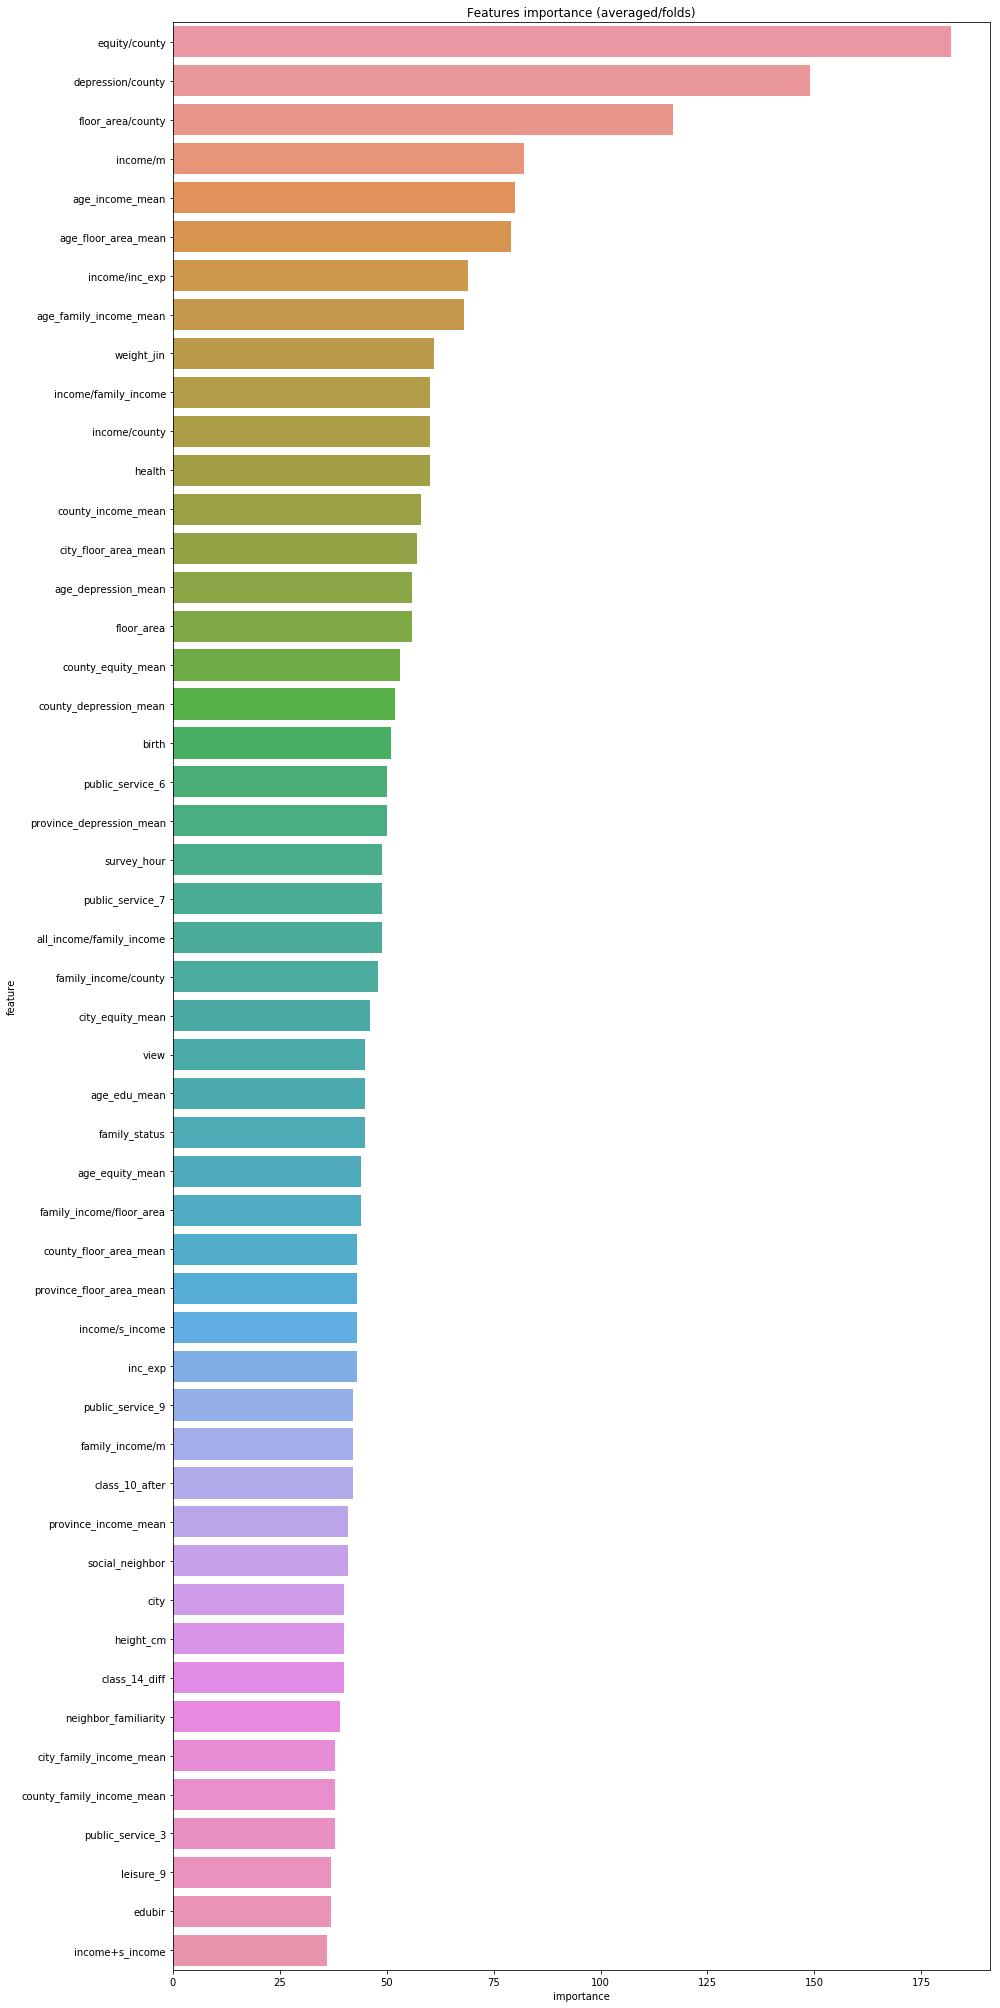

In [12]:
#---------------特征重要性
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', None)
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',100)
df = pd.DataFrame(data[use_fea].columns.tolist(), columns=['feature'])
df['importance']=list(clf.feature_importance())
df = df.sort_values(by='importance',ascending=False)
plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="feature", data=df.head(50))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()

In [13]:
##### xgb
xgb_params = {'eta': 0.05, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True, 'nthread': 4}

X_train_use = data[use_fea][:train_shape].values
X_test_use = data[use_fea][train_shape:].values

folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_xgb = np.zeros(train_shape)
predictions_xgb = np.zeros(len(X_test_use))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = xgb.DMatrix(X_train[trn_idx], y_train[trn_idx])
    val_data = xgb.DMatrix(X_train[val_idx], y_train[val_idx])

    watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
    clf = xgb.train(dtrain=trn_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=100, params=xgb_params)
    oof_xgb[val_idx] = clf.predict(xgb.DMatrix(X_train[val_idx]), ntree_limit=clf.best_ntree_limit)
    predictions_xgb += clf.predict(xgb.DMatrix(X_test), ntree_limit=clf.best_ntree_limit) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_xgb, target)))

fold n°1
[0]	train-rmse:3.30160	valid_data-rmse:3.29425
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[100]	train-rmse:0.22538	valid_data-rmse:0.68081
[200]	train-rmse:0.09082	valid_data-rmse:0.67994
[300]	train-rmse:0.03481	valid_data-rmse:0.67987
Stopping. Best iteration:
[140]	train-rmse:0.15710	valid_data-rmse:0.67909

fold n°2
[0]	train-rmse:3.29522	valid_data-rmse:3.32381
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[100]	train-rmse:0.23174	valid_data-rmse:0.68018
[200]	train-rmse:0.09108	valid_data-rmse:0.67757
[300]	train-rmse:0.03389	valid_data-rmse:0.67820
Stopping. Best iteration:
[170]	train-rmse:0.12229	valid_data-rmse:0.67703

fold n°3
[0]	train-rmse:3.30797	valid_data-rmse:3.26893
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for

In [14]:
# 将lgb和xgb的结果进行stacking
train_stack = np.vstack([oof_lgb,oof_xgb]).transpose()
test_stack = np.vstack([predictions_lgb, predictions_xgb]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4590)
oof_stack = np.zeros(train_stack.shape[0])
predictions = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values
    
    clf_3 = BayesianRidge()
    clf_3.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf_3.predict(val_data)
    predictions += clf_3.predict(test_stack) / 10
    
mean_squared_error(target.values, oof_stack) 

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9


0.45991074333945803

In [15]:
submit_example['happiness'] = predictions
now = datetime.now().strftime('%m-%d-%H-%M')
submit_example.to_csv("./baseline_%s.csv" % now, index=False)
submit_example.head()

,id,happiness
0,8001,3.764613
1,8002,2.894508
2,8003,3.234379
3,8004,4.393835
4,8005,3.304932
